# Multi-GS Classifier
### Attempt to label events with gluon splitting and differentiate types of gluon splitting

### Labels: 0 = noGS, 1 = GSb , 2 = GSbb

## Setup the data

In [3]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('/Users/rohan/research/gs_classifier/output_multigs.csv')

feats = df.iloc[:,0:12]
y = df.isgs

In [5]:
feats.shape

(164656, 12)

In [6]:
feats.head(5)

,weight,dr_bb,bb_pt,bb_m,jet1_csv,jet1_pt,jet1_eta,jet1_phi,jet2_csv,jet2_pt,jet2_eta,jet2_phi
0,0.068587,0.947933,806.513000,418.969666,0.970258,469.232178,-1.552434,0.988524,0.906826,340.613373,-0.622500,1.172366
1,0.065783,1.710818,345.106720,202.336594,0.993821,47.740227,1.110587,-1.902524,0.958397,346.806488,0.763946,-0.227192
2,0.069150,0.821434,699.727417,307.803986,0.996421,344.196381,0.981522,-0.860860,0.901411,418.045929,1.034307,-0.041124
3,0.069805,1.968648,235.376617,302.447571,0.987000,153.347351,0.517652,0.096551,0.862928,140.702484,-0.972188,1.383389
4,0.068559,1.061551,743.231018,418.841614,0.907696,374.111206,0.631812,1.520363,0.853196,370.016937,-0.425185,1.618583


In [7]:
y.shape

(164656,)

In [8]:
y.head(5)

0    2
1    2
2    0
3    1
4    0
Name: isgs, dtype: int64

#### Use K-folds for cross-validation

In [5]:
from sklearn.model_selection import KFold
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=452)

## Decision Tree
#### Loop over the folds, train, and evaluate the decision tree

In [6]:
def get_cm_gs(mat, norm=False):
    if mat.shape != (3,3): print("Matrix shape must be (3,3)")
        
    cm_gs = mat
    cm_gs[1,:]+=cm_gs[2,:]
    cm_gs[:,1]+=cm_gs[:,2]
    cm_gs = cm_gs[:2,:2]
    
    if norm:
        return(cm_gs/cm_gs.sum(axis=1)[:, np.newaxis])
    else:
        return(cm_gs)

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import label_binarize
tree = DecisionTreeClassifier(random_state=368)
cm_trains = np.zeros((3,3))
cm_tests = np.zeros((3,3))
for idx, (train, test) in enumerate(kf.split(feats, y)):
    # Setup weights and train/test sets
    train_weights = list(feats.iloc[train,0])
    X_train, y_train = feats.iloc[train,1:12], y.iloc[train]
    test_weights = list(feats.iloc[test,0])
    X_test, y_test = feats.iloc[test, 1:12], y.iloc[test]
    
    # Train tree
    tree.fit(X_train, y_train, sample_weight=train_weights)

    # Evaluate with confusion matrix
    # Print accuracy for each fold and the summed confusion matrix at the end
    print("Fold {}:").format(idx+1)

    cm_train = confusion_matrix(y_train, tree.predict(X_train), sample_weight=train_weights)
    print("\tTrain accuracy: {:.3f}").format(cm_train.trace()/cm_train.sum())
    cm_trains += cm_train
    
    cm_test = confusion_matrix(y_test, tree.predict(X_test), sample_weight=test_weights)
    print("\tTest accuracy: {:.3f}\n").format(cm_test.trace()/cm_test.sum())
    cm_tests += cm_test
    
print("Mean train accuracy: {:.3f}").format(cm_trains.trace()/cm_trains.sum())
print("Train CM:\n {}\n").format(cm_trains.round(3))
print("Norm. Train CM:\n {}\n").format(cm_trains/cm_trains.sum(axis=1))
print("Mean test accuracy: {:.3f}").format(cm_tests.trace()/cm_tests.sum())
print("Test CM:\n {}\n").format(cm_tests.round(3))
print("Norm. Test CM:\n {} \n").format(cm_tests/cm_tests.sum(axis=1)[:, np.newaxis])
print("Norm. Test CM GS:\n {}").format(get_cm_gs(cm_tests,True))

Fold 1:
	Train accuracy: 1.000
	Test accuracy: 0.483

Fold 2:
	Train accuracy: 1.000
	Test accuracy: 0.472

Fold 3:
	Train accuracy: 1.000
	Test accuracy: 0.477

Fold 4:
	Train accuracy: 1.000
	Test accuracy: 0.478

Fold 5:
	Train accuracy: 1.000
	Test accuracy: 0.472

Mean train accuracy: 1.000
Train CM:
 [[ 2930.166     0.        0.   ]
 [    0.     1755.733     0.   ]
 [    0.        0.      880.591]]

Norm. Train CM:
 [[ 1.  0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]

Mean test accuracy: 0.476
Test CM:
 [[ 402.475  232.988   97.079]
 [ 205.903  177.405   55.625]
 [  83.284   54.169   82.695]]

Norm. Test CM:
 [[ 0.54942287  0.31805365  0.13252349]
 [ 0.46909773  0.4041737   0.12672857]
 [ 0.37830829  0.24605875  0.37563296]] 

Norm. Test CM GS:
 [[ 0.54942287  0.45057713]
 [ 0.43877202  0.56122798]]


## Try Limiting Max Depth 

In [12]:
depth_trees = []
for depth in range(1,15):
    print("Depth {}:").format(depth)
    tree = DecisionTreeClassifier(random_state=368, max_depth=depth)
    cm_trains = np.zeros((3,3))
    cm_tests = np.zeros((3,3))
    for idx, (train, test) in enumerate(kf.split(feats, y)):
        # Setup weights and train/test sets
        train_weights = list(feats.iloc[train,0])
        X_train, y_train = feats.iloc[train,1:12], y.iloc[train]
        test_weights = list(feats.iloc[test,0])
        X_test, y_test = feats.iloc[test, 1:12], y.iloc[test]
    
        # Train tree
        tree.fit(X_train, y_train, sample_weight=train_weights)

        # Evaluate with confusion matrix
        # Print accuracy for each fold and the summed confusion matrix at the end
        cm_train = confusion_matrix(y_train, tree.predict(X_train), sample_weight=train_weights)
        cm_trains += cm_train
    
        cm_test = confusion_matrix(y_test, tree.predict(X_test), sample_weight=test_weights)
        cm_tests += cm_test
    
    print("Mean train accuracy: {:.3f}").format(cm_trains.trace()/cm_trains.sum())
    print("Mean test accuracy: {:.3f}").format(cm_tests.trace()/cm_tests.sum())

    mat_cm_gs = get_cm_gs(cm_tests)
    print("Mean test gs accuracy: {:.3f}\n").format(mat_cm_gs.trace()/mat_cm_gs.sum())
    
    print("Test CM:\n {}\n").format(cm_tests.round(3))
    print("Norm. Test CM:\n {} \n").format(cm_tests/cm_tests.sum(axis=1)[:, np.newaxis])
    print("Norm. Test CM GS:\n {}\n").format(get_cm_gs(cm_tests,True))
    print("{}\n").format(tree.feature_importances_)

Depth 1:
Mean train accuracy: 0.526
Mean test accuracy: 0.526
Mean test gs accuracy: 0.526

Test CM:
 [[ 732.542    0.       0.   ]
 [ 659.081    0.       0.   ]
 [ 220.148    0.       0.   ]]

Norm. Test CM:
 [[ 1.  0.  0.]
 [ 1.  0.  0.]
 [ 1.  0.  0.]] 

Norm. Test CM GS:
 [[ 1.  0.]
 [ 1.  0.]]

[ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

Depth 2:
Mean train accuracy: 0.543
Mean test accuracy: 0.542
Mean test gs accuracy: 0.560

Test CM:
 [[ 563.324  169.218    0.   ]
 [ 443.502  215.579    0.   ]
 [ 195.845   24.303    0.   ]]

Norm. Test CM:
 [[ 0.76899936  0.23100064  0.        ]
 [ 0.67290961  0.32709039  0.        ]
 [ 0.88960532  0.11039468  0.        ]] 

Norm. Test CM GS:
 [[ 0.76899936  0.23100064]
 [ 0.72716749  0.27283251]]

[ 0.49109494  0.          0.          0.50890506  0.          0.          0.
  0.          0.          0.          0.        ]

Depth 3:
Mean train accuracy: 0.566
Mean test accuracy: 0.564
Mean test gs accuracy: 0.609

Test CM:
 [[ 520.     212.5

In [13]:
# The classifiers seem to prefer bb_m and jet1_csv as the most important variables

<function matplotlib.pyplot.show>

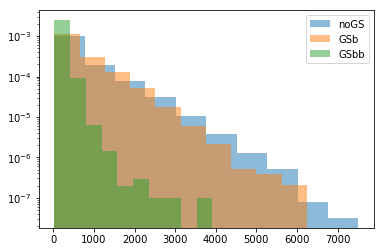

In [14]:
plt.hist(df[df.isgs==0].bb_m, alpha=0.5, label='noGS', log=True, normed=True)
plt.hist(df[df.isgs==1].bb_m, alpha=0.5, label='GSb', normed=True)
plt.hist(df[df.isgs==2].bb_m, alpha=0.5, label='GSbb', normed=True)
plt.legend(loc='upper right')
plt.show

<function matplotlib.pyplot.show>

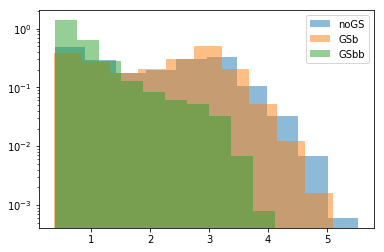

In [19]:
plt.hist(df[df.isgs==0].dr_bb, alpha=0.5, label='noGS', log=True, normed=True)
plt.hist(df[df.isgs==1].dr_bb, alpha=0.5, label='GSb', normed=True)
plt.hist(df[df.isgs==2].dr_bb, alpha=0.5, label='GSbb', normed=True)
plt.legend(loc='upper right')
plt.show

<function matplotlib.pyplot.show>

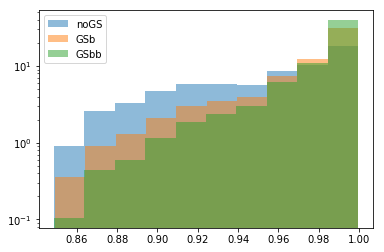

In [15]:
plt.hist(df[df.isgs==0].jet1_csv, alpha=0.5, label='noGS', log=True, normed=True)
plt.hist(df[df.isgs==1].jet1_csv, alpha=0.5, label='GSb', normed=True)
plt.hist(df[df.isgs==2].jet1_csv, alpha=0.5, label='GSbb', normed=True)
plt.legend(loc='upper left')
plt.show

<function matplotlib.pyplot.show>

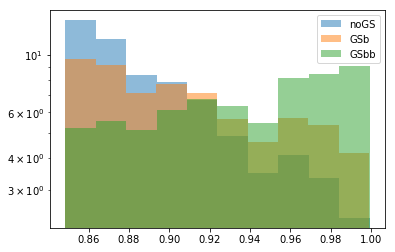

In [18]:
plt.hist(df[df.isgs==0].jet2_csv, alpha=0.5, label='noGS', log=True, normed=True)
plt.hist(df[df.isgs==1].jet2_csv, alpha=0.5, label='GSb', normed=True)
plt.hist(df[df.isgs==2].jet2_csv, alpha=0.5, label='GSbb', normed=True)
plt.legend(loc='upper right')
plt.show

<function matplotlib.pyplot.show>

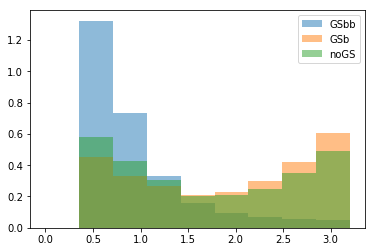

In [16]:
bins = np.linspace(0,3.2,10)
plt.hist(df[df.isgs==2].dr_bb, bins, alpha=0.5, label='GSbb', normed=True)
plt.hist(df[df.isgs==1].dr_bb, bins, alpha=0.5, label='GSb', normed=True)
plt.hist(df[df.isgs==0].dr_bb, bins, alpha=0.5, label='noGS', normed=True)
plt.legend(loc='upper right')
plt.show

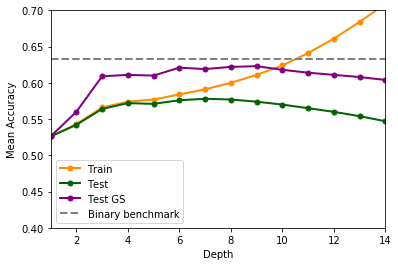

In [14]:
train_scores = [0.526, 0.543, 0.566, 0.574, 0.577, 0.584, 0.591, 0.600, 0.611, 0.624, 0.641, 0.661, 0.684, 0.709]
test_scores = [0.526, 0.542, 0.564, 0.572, 0.571, 0.576, 0.578, 0.577, 0.574, 0.570, 0.565, 0.560, 0.554, 0.547]
test_gs_scores = [0.526, 0.560, 0.609, 0.611, 0.610, 0.621, 0.619, 0.622, 0.623, 0.618, 0.614, 0.611, 0.608, 0.604]

# Plot train/test scores as a function of depth
plt.plot(range(1,15), train_scores, color='darkorange', label = 'Train', lw=2, marker='.', ms=10)
plt.plot(range(1,15), test_scores, color='darkgreen', label = 'Test', lw=2, marker='.', ms=10)
plt.plot(range(1,15), test_gs_scores, color='purple', label = 'Test GS', lw=2, marker='.', ms=10)
plt.plot([1,15],[0.633,0.633], color='grey', lw = 2, linestyle='--', label='Binary benchmark')
plt.xlim([1,14])
plt.ylim([0.4, 0.7])
plt.xlabel('Depth')
plt.ylabel('Mean Accuracy')
plt.legend(loc='lower left')
plt.show()